In [42]:
import pandas as pd
import numpy as np
import csv
from scipy.sparse import *
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import surprise
from surprise import Dataset, Reader
from surprise import SVD
from surprise.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [3]:
# load datasets
impression_data = pd.read_csv('impression_data.csv', sep = ',')

In [10]:
impression_data

,detailMlogInfoList,dt,impressPosition,impressTime,isClick,isComment,isIntoPersonalHomepage,isShare,isViewComment,isZan,mlogId,mlogViewTime,userId
0,NaN,29,1,1574980776000,0,0,0,0,0,0,NCLCPCJCOCGCJC,NaN,PCNCGCGCLCOCOCOCJCGC
1,NaN,25,6,1574684613000,0,0,0,0,0,0,KCNCOCNCMCOCMC,NaN,PCNCGCGCLCOCOCOCJCGC
2,"[{'isZan': '0', 'isComment': '0', 'mlogId': 'K...",25,1,1574684241000,1,0,0,0,0,0,NCHCGCICLCPCGC,2.98,PCNCGCGCLCOCOCOCJCGC
3,NaN,15,3,1573767973000,0,0,0,0,0,0,PCNCNCPCICLCGC,NaN,PCNCGCGCLCOCOCOCJCGC
4,NaN,15,2,1573767973000,0,0,0,0,0,0,NCHCICPCOCLCOC,NaN,PCNCGCGCLCOCOCOCJCGC
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57750390,NaN,20,4,1574217952000,0,0,0,0,0,0,MCPCGCOCLCGCLC,NaN,LCPCLCHCNCPCJCHCHC
57750391,NaN,20,2,1574218006000,0,0,0,0,0,0,NCLCICNCGCMCOC,NaN,LCPCLCHCNCPCJCHCHC
57750392,NaN,20,1,1574214635000,0,0,0,0,0,0,KCMCKCKCLCLCGC,NaN,LCPCLCHCNCPCJCHCHC
57750393,NaN,4,2,1572844108000,0,0,0,0,0,0,NCHCMCMCHCMCKC,NaN,LCPCLCHCNCPCJCHCHC


# K-Means Clustering

In [4]:
total_impression =  impression_data['userId'].value_counts()

In [5]:
# formulate the three-columns matrix
engagement= impression_data[['isClick', 'isComment', 'isZan', 'isShare', 'isViewComment', 'isIntoPersonalHomepage']]
engagement = engagement.sum(axis=1)
Id = impression_data[['userId', 'mlogId']]
df = pd.concat([Id, engagement], axis=1)
df.columns =['userId', 'mlogId', 'engagement']

In [6]:
df

,userId,mlogId,engagement
0,PCNCGCGCLCOCOCOCJCGC,NCLCPCJCOCGCJC,0
1,PCNCGCGCLCOCOCOCJCGC,KCNCOCNCMCOCMC,0
2,PCNCGCGCLCOCOCOCJCGC,NCHCGCICLCPCGC,1
3,PCNCGCGCLCOCOCOCJCGC,PCNCNCPCICLCGC,0
4,PCNCGCGCLCOCOCOCJCGC,NCHCICPCOCLCOC,0
...,...,...,...
57750390,LCPCLCHCNCPCJCHCHC,MCPCGCOCLCGCLC,0
57750391,LCPCLCHCNCPCJCHCHC,NCLCICNCGCMCOC,0
57750392,LCPCLCHCNCPCJCHCHC,KCMCKCKCLCLCGC,0
57750393,LCPCLCHCNCPCJCHCHC,NCHCMCMCHCMCKC,0


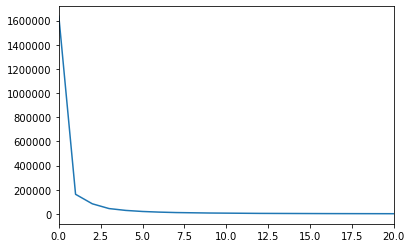

In [7]:
user_engagement = df.groupby('userId')['engagement'].sum()
user_engagement.value_counts().plot(xlim = [0,20])

In [72]:
df_user = pd.DataFrame(columns = ['total_impression', 'total_engagement'])
df_user['total_impression'] = total_impression
df_user['total_engagement'] = user_engagement

In [63]:
df_user

,total_impression,total_engagement
PCLCKCOCKCHCGCHCICMC,23121,409
PCNCGCJCOCOCOCPCNCJC,20652,1100
PCKCNCICMCLCICKCKCPC,20642,30
PCICHCPCPCNCICGCPCPC,17463,686
LCNCGCHCOCGCKCKCPC,15422,409
...,...,...
PCGCPCHCLCHCMCICGCPC,1,0
NCPCLCHCKCOCICMCPC,1,0
MCOCNCJCJCOCLCNCGCLC,1,0
PCMCJCLCJCOCLCJCJC,1,0


In [10]:
kmeans = KMeans(n_clusters=4).fit(df_user)
labels = kmeans.labels_
cluster_results = pd.DataFrame([df_user.index,labels]).T

In [21]:
cluster_results.columns = ['userId', 'cluster']
clus = cluster_results.set_index('userId')

In [22]:
clus

,cluster
userId,
PCLCKCOCKCHCGCHCICMC,3
PCNCGCJCOCOCOCPCNCJC,3
PCKCNCICMCLCICKCKCPC,3
PCICHCPCPCNCICGCPCPC,3
LCNCGCHCOCGCKCKCPC,3
...,...
PCGCPCHCLCHCMCICGCPC,0
NCPCLCHCKCOCICMCPC,0
MCOCNCJCJCOCLCNCGCLC,0


In [73]:
df_user['cluster'] = clus

In [74]:
df_user

,total_impression,total_engagement,cluster
PCLCKCOCKCHCGCHCICMC,23121,409,3
PCNCGCJCOCOCOCPCNCJC,20652,1100,3
PCKCNCICMCLCICKCKCPC,20642,30,3
PCICHCPCPCNCICGCPCPC,17463,686,3
LCNCGCHCOCGCKCKCPC,15422,409,3
...,...,...,...
PCGCPCHCLCHCMCICGCPC,1,0,0
NCPCLCHCKCOCICMCPC,1,0,0
MCOCNCJCJCOCLCNCGCLC,1,0,0
PCMCJCLCJCOCLCJCJC,1,0,0


# Formulate Train & Test Datasets for SVD factorization

In [28]:
# users with first-seven-days data
user_7 = impression_data[impression_data['dt']<=7]['userId'].unique()
mlog_7 = impression_data[impression_data['dt']<=7]['mlogId'].unique()

In [29]:
NA, test_user_7 = train_test_split(user_7, test_size=0.3)

In [30]:
df_test = df[df['userId'].isin(test_user_7) & df['mlogId'].isin(mlog_7)]

In [31]:
df_test

,userId,mlogId,engagement
0,PCNCGCGCLCOCOCOCJCGC,NCLCPCJCOCGCJC,0
3,PCNCGCGCLCOCOCOCJCGC,PCNCNCPCICLCGC,0
4,PCNCGCGCLCOCOCOCJCGC,NCHCICPCOCLCOC,0
5,PCNCGCGCLCOCOCOCJCGC,NCJCNCHCICICGC,0
6,PCNCGCGCLCOCOCOCJCGC,NCHCPCPCOCOCLC,0
...,...,...,...
57750388,LCPCLCHCNCPCJCHCHC,GCICICICICJC,0
57750389,LCPCLCHCNCPCJCHCHC,NCICNCPCOCLCJC,0
57750390,LCPCLCHCNCPCJCHCHC,MCPCGCOCLCGCLC,0
57750391,LCPCLCHCNCPCJCHCHC,NCLCICNCGCMCOC,0


In [32]:
df_train = df[~df['userId'].isin(test_user_7)]

In [33]:
df_train

,userId,mlogId,engagement
7,PCNCGCHCPCJCICLCLCIC,MCHCLCGCKCNCNC,0
8,PCNCGCHCPCJCICLCLCIC,NCMCMCMCKCHCPC,0
9,PCNCGCHCPCJCICLCLCIC,NCKCHCJCMCICNC,0
10,PCNCGCHCPCJCICLCLCIC,MCGCOCPCKCOCNC,0
11,PCNCGCHCPCJCICLCLCIC,NCMCMCKCOCNCPC,0
...,...,...,...
57750290,LCPCKCHCNCLCJCMCHC,NCNCHCHCPCHCNC,0
57750291,LCPCKCHCNCLCJCMCHC,KCNCHCOCKCGCPC,0
57750292,LCPCLCOCPCOCKCICJC,HCLCJCNCLCHC,0
57750293,LCPCLCOCPCOCKCICJC,KCNCJCLCNCGCPC,0


In [75]:
cluster_train = df_user[df_user.index.isin(df_train['userId'])]

In [82]:
cluster_train = cluster_train.reset_index()
cluster_train.columns = ['userId', 'total_impression', 'total_engagement', 'cluster']

In [77]:
df_user = df_user.reset_index()
df_user.columns = ['userId', 'total_impression', 'total_engagement', 'cluster']

In [56]:
cluster_results.pivot_table(index=['cluster'], aggfunc='size')

cluster
0    2037498
1       3694
2      44156
3        254
dtype: int64

In [130]:
over = RandomOverSampler(sampling_strategy={1:20000, 3:20000})
under = RandomUnderSampler(sampling_strategy={0:20000, 2:20000})
pipeline = Pipeline(steps=[('o', over), ('u', under)])

In [131]:
# resample the imbalanced training set
user_res, clu_res = pipeline.fit_resample(cluster_train[['userId','total_impression', 'total_engagement']], cluster_train['cluster'].astype('int'))

In [132]:
user_res

,userId,total_impression,total_engagement
0,LCHCICICGCJCPCOCLC,33,0
1,KCKCMCLCICGCJCKCIC,8,0
2,LCGCKCGCPCMCKCHCLC,9,0
3,LCNCHCKCICNCPCLCJC,11,0
4,NCHCLCPCICKCKCNCIC,9,1
...,...,...,...
79995,MCICKCGCGCLCKCHCIC,4908,173
79996,LCICJCPCICNCGCICIC,3655,194
79997,PCKCLCICNCOCKCMCJCIC,3825,758
79998,PCGCKCPCMCGCOCMCMCKC,8468,18


In [133]:
df_train_res = df_train[df_train['userId'].isin(user_res['userId'])]

In [116]:
df_train_res['userId'].unique()[6183]

'KCNCLCGCJCNCJCOCOC'

In [134]:
len(df_test['userId'].unique())

252501

In [135]:
df_svd = pd.concat([df_train_res, df_test])

In [136]:
df_svd

,userId,mlogId,engagement
56,PCNCGCHCNCGCMCGCPCJC,GCPCJCPCNCGC,0
57,PCNCGCHCNCGCMCGCPCJC,GCPCJCPCNCGC,0
58,PCNCGCHCNCGCMCGCPCJC,NCGCMCMCPCNCOC,0
59,PCNCGCHCNCGCMCGCPCJC,MCHCICKCHCMCOC,0
60,PCNCGCHCNCGCMCGCPCJC,KCLCNCNCJCMCHC,0
...,...,...,...
57750388,LCPCLCHCNCPCJCHCHC,GCICICICICJC,0
57750389,LCPCLCHCNCPCJCHCHC,NCICNCPCOCLCJC,0
57750390,LCPCLCHCNCPCJCHCHC,MCPCGCOCLCGCLC,0
57750391,LCPCLCHCNCPCJCHCHC,NCLCICNCGCMCOC,0


In [94]:
reader = Reader(rating_scale = (0.5,5))
data_svd = Dataset.load_from_df(df_svd, reader)
dt_svd = data_svd.build_full_trainset()

In [137]:
SVD_model = SVD(biased = False) 
SVD_model.fit(dt_svd)

In [138]:
dt_pu = pd.DataFrame(SVD_model.pu)
dt_pu.to_csv(r'pu_res_1.csv')

The first 0-618300 rows are of users from the training set. And the rest 252501 rows are from the test set.

Have finished training the SVD model, begin testing now.

In [139]:
len_train = len(df_train_res['userId'].unique())

In [140]:
len_test = len(df_test['userId'].unique())

In [141]:
train_pu = np.asmatrix(SVD_model.pu[:6183])  

In [ ]:
dict = {}
w = csv.writer(open("pred_res.csv", "w"))
for i in range(len_test):
    k = i + len_train
    test_pu = np.asmatrix(SVD_model.pu[k])    
    cos_sim = test_pu@train_pu.T
    target_uid = np.unravel_index(np.argmax(cos_sim, axis=None), cos_sim.shape)[1]
    target = dt_svd.to_raw_uid(target_uid)
    clus = cluster_results[cluster_results['userId'] == target]['cluster']
    dict[dt_svd.to_raw_uid(k)] = clus.values[0]
    if i%1000 == 0:
        for key, val in dict.items():
            w.writerow([key, val])

In [ ]:
dict